# Quick exploration of recent extragalactic transient candidates

Select recent supernova candidates from the different ALeRCE classifiers

Francisco Förster, 20241207

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.time import Time
from datetime import datetime

In [3]:
import sqlalchemy as sa

In [4]:
import requests

ALeRCE client

In [5]:
#!pip install alerce
from alerce.core import Alerce
client = Alerce()

### Connect to DB

In [6]:
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [7]:
engine = sa.create_engine(f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}")
engine.begin()

Get table names

In [8]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, con=engine)
tables.sort_values(by="table_name")

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,forced_photometry
6,gaia_ztf
7,lc_classifier
8,lc_classifier_periodic
9,lc_classifier_stochastic


Get all column names for every table

In [9]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, con=engine)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


Show the taxonomy for the different classifiers

In [10]:
query = "select * from taxonomy"
classes = pd.read_sql_query(query, con=engine)
classes

,classifier_name,classifier_version,classes
0,lc_classifier_transient,hierarchical_random_forest_1.0.0,"[SNIa, SNIbc, SNII, SLSN]"
1,lc_classifier_stochastic,hierarchical_random_forest_1.0.0,"[QSO, AGN, Blazar, CV/Nova, YSO]"
2,lc_classifier_periodic,hierarchical_random_forest_1.0.0,"[LPV, E, DSCT, RRL, CEP, Periodic-Other]"
3,LC_classifier_ATAT_forced_phot(beta),beta,"[SNIa, SNIbc, SNIIb, SNII, SNIIn, SLSN, TDE, M..."
4,LC_classifier_BHRF_forced_phot(beta),beta,"[SNIa, SNIbc, SNIIb, SNII, SNIIn, SLSN, TDE, M..."
5,lc_classifier,hierarchical_random_forest_1.0.0,"[SNIa, SNIbc, SNII, SLSN, QSO, AGN, Blazar, CV..."
6,lc_classifier_top,hierarchical_random_forest_1.0.0,"[Transient, Stochastic, Periodic]"
7,stamp_classifier,stamp_classifier_1.0.0,"[SN, AGN, VS, asteroid, bogus]"
8,stamp_classifier,stamp_classifier_1.0.4,"[SN, AGN, VS, asteroid, bogus]"


# Classifier transient classes and recommended classifier versions

In [11]:
# classifier taxonomies
transients = {}
transients["stamp_classifier"] = ["SN", "AGN"] # we include AGN because they might be TDEs
transients["lc_classifier"] = ['SNIa', 'SNIbc', 'SNII', 'SLSN']
transients["LC_classifier_ATAT_forced_phot(beta)"] = ['SNIa', 'SNIbc', 'SNIIb', 'SNII', 'SNIIn', 'SLSN', 'TDE']
transients["LC_classifier_BHRF_forced_phot(beta)"] = ['SNIa', 'SNIbc', 'SNIIb', 'SNII', 'SNIIn', 'SLSN', 'TDE']

# confirm with the ALeRCE team about the recommended version
classifier_version = {}
classifier_version["stamp_classifier"] = "stamp_classifier_1.0.4"
classifier_version["lc_classifier"] = "lc_classifier_1.1.13"
classifier_version["LC_classifier_ATAT_forced_phot(beta)"] = "0.3.1"
classifier_version["LC_classifier_BHRF_forced_phot(beta)"] = "1.1.1"

### Query objects that appeared during the last two days, that are classified as most likely supernova or AGN by the stamp classifier with a probability larger than 0.4

In [12]:
ndays = 2
mjd_last = Time(datetime.utcnow(), scale='utc').mjd - ndays

sn = {}

query='''
SELECT
    object.oid, object.meanra, object.meandec, object.firstmjd,
    object.ndet, object.stellar, probability.probability, 
    probability.classifier_name, probability.classifier_version,
    probability.class_name
FROM 
    object 
INNER JOIN
    probability
ON 
    object.oid = probability.oid
WHERE
    object.firstMJD > %s
    AND probability.classifier_name = 'stamp_classifier'
    AND probability.class_name IN (%s)
    AND probability.ranking=1
    AND probability.probability>0.4
''' % (mjd_last, ",".join([f"'{i}'" for i in transients["stamp_classifier"]]))

sn["stamp_classifier"] = pd.read_sql_query(query, con=engine)
sn["stamp_classifier"].set_index('oid', inplace=True)
print(sn['stamp_classifier'].shape)
sn["stamp_classifier"].head()

(513, 9)


,meanra,meandec,firstmjd,ndet,stellar,probability,classifier_name,classifier_version,class_name
oid,,,,,,,,,
ZTF24abwmcyu,341.344296,38.276729,60650.175972,1,False,0.527966,stamp_classifier,stamp_classifier_1.0.4,SN
ZTF24abwmcxb,338.494361,49.489542,60650.176435,1,False,0.427879,stamp_classifier,stamp_classifier_1.0.4,AGN
ZTF24abwmdmk,337.978998,46.887884,60650.176435,1,False,0.563600,stamp_classifier,stamp_classifier_1.0.4,AGN
ZTF24abwmdrs,339.097547,46.788207,60650.176435,1,False,0.433318,stamp_classifier,stamp_classifier_1.0.4,AGN
ZTF19adnlgqr,328.863025,63.787359,60650.176944,1,False,0.401095,stamp_classifier,stamp_classifier_1.0.4,AGN


Plot a histogram of discovery dates

Text(0.5, 0, 'firstmjd')

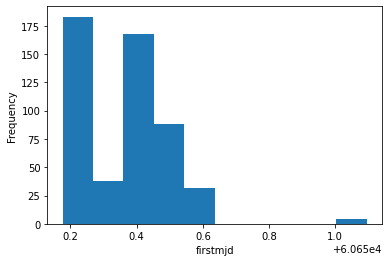

In [13]:
fig, ax = plt.subplots()
sn["stamp_classifier"].firstmjd.plot.hist(ax=ax)
ax.set_xlabel("firstmjd")

Bar plot of classes

<Axes: >

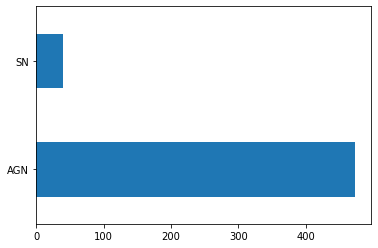

In [14]:
sn["stamp_classifier"].class_name.value_counts().plot.barh()

Plot histograms of probabilities divided by class

Text(0.5, 0, 'probability')

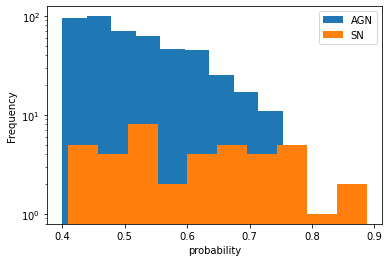

In [15]:
fig, ax = plt.subplots()
sn["stamp_classifier"].groupby("class_name").apply(lambda df: df.probability.plot.hist(label=df.class_name[0], log=True, legend=True, ax=ax))
ax.set_xlabel("probability")

#  Query objects that appeared during the last month, that are classified as most likely transient by any of the the light curve classifiers

Check the classifier and class names

In [16]:
print(classes.loc[classes.classifier_name=="lc_classifier"].classes.to_list())
print(classes.loc[classes.classifier_name=="LC_classifier_ATAT_forced_phot(beta)"].classes.to_list())
print(classes.loc[classes.classifier_name=="LC_classifier_BHRF_forced_phot(beta)"].classes.to_list())

[['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'CV/Nova', 'YSO', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']]
[['SNIa', 'SNIbc', 'SNIIb', 'SNII', 'SNIIn', 'SLSN', 'TDE', 'Microlensing', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'EA', 'EB/EW', 'Periodic-Other', 'RSCVn', 'CEP', 'RRLab', 'RRLc', 'DSCT']]
[['SNIa', 'SNIbc', 'SNIIb', 'SNII', 'SNIIn', 'SLSN', 'TDE', 'Microlensing', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'EA', 'EB/EW', 'Periodic-Other', 'RSCVn', 'CEP', 'RRLab', 'RRLc', 'DSCT']]


Query by classifier, this time we will require at least six detections since the forced photometry classifiers can be applied with even 2 detections and the light curve requires at least six detections in the same band.

In [17]:
ndays = 30
mjd_last = Time(datetime.utcnow(), scale='utc').mjd - ndays

for clf in ["lc_classifier", "LC_classifier_ATAT_forced_phot(beta)", "LC_classifier_BHRF_forced_phot(beta)"]:
    query=f'''
    SELECT
        object.oid, object.meanra, object.meandec, object.firstmjd,
        object.ndet, object.stellar, probability.classifier_name, probability.classifier_version,
        probability.class_name, probability.probability
    FROM 
        object 
    INNER JOIN
        probability
    ON 
        object.oid = probability.oid
    WHERE
        object.firstMJD > {mjd_last}
        AND probability.classifier_name='{clf}'
        AND probability.class_name IN ({",".join([f"'{i}'" for i in transients[clf]])})
        AND probability.ranking=1
        AND probability.classifier_version='{classifier_version[clf]}'
        AND object.ndet > 5
    '''
    print(query)
    sn[clf] = pd.read_sql_query(query, con=engine)
    sn[clf].set_index('oid', inplace=True)
    print(sn[clf].shape)
    display(sn[clf].head())


    SELECT
        object.oid, object.meanra, object.meandec, object.firstmjd,
        object.ndet, object.stellar, probability.classifier_name, probability.classifier_version,
        probability.class_name, probability.probability
    FROM 
        object 
    INNER JOIN
        probability
    ON 
        object.oid = probability.oid
    WHERE
        object.firstMJD > 60621.70744353736
        AND probability.classifier_name='lc_classifier'
        AND probability.class_name IN ('SNIa','SNIbc','SNII','SLSN')
        AND probability.ranking=1
        AND probability.classifier_version='lc_classifier_1.1.13'
        AND object.ndet > 5
    
(2, 9)


,meanra,meandec,firstmjd,ndet,stellar,classifier_name,classifier_version,class_name,probability
oid,,,,,,,,,
ZTF24absdzss,201.483700,5.350852,60624.551111,10,False,lc_classifier,lc_classifier_1.1.13,SNIa,0.177600
ZTF18adavlie,110.809029,-27.698128,60628.463021,12,False,lc_classifier,lc_classifier_1.1.13,SNIbc,0.232464



    SELECT
        object.oid, object.meanra, object.meandec, object.firstmjd,
        object.ndet, object.stellar, probability.classifier_name, probability.classifier_version,
        probability.class_name, probability.probability
    FROM 
        object 
    INNER JOIN
        probability
    ON 
        object.oid = probability.oid
    WHERE
        object.firstMJD > 60621.70744353736
        AND probability.classifier_name='LC_classifier_ATAT_forced_phot(beta)'
        AND probability.class_name IN ('SNIa','SNIbc','SNIIb','SNII','SNIIn','SLSN','TDE')
        AND probability.ranking=1
        AND probability.classifier_version='0.3.1'
        AND object.ndet > 5
    
(219, 9)


,meanra,meandec,firstmjd,ndet,stellar,classifier_name,classifier_version,class_name,probability
oid,,,,,,,,,
ZTF24abriexo,150.061217,10.452207,60622.494803,13,False,LC_classifier_ATAT_forced_phot(beta),0.3.1,SNIa,0.773508
ZTF24abvdzbs,91.323936,72.154265,60646.394306,6,False,LC_classifier_ATAT_forced_phot(beta),0.3.1,SNIa,0.976591
ZTF24abrgpqk,38.594785,7.214614,60622.291470,21,False,LC_classifier_ATAT_forced_phot(beta),0.3.1,SNIa,0.954248
ZTF24abrpdla,126.261860,4.274845,60624.470174,13,False,LC_classifier_ATAT_forced_phot(beta),0.3.1,SNIa,0.940474
ZTF24abrirtr,202.366263,11.006277,60622.545417,12,False,LC_classifier_ATAT_forced_phot(beta),0.3.1,SNII,0.959634



    SELECT
        object.oid, object.meanra, object.meandec, object.firstmjd,
        object.ndet, object.stellar, probability.classifier_name, probability.classifier_version,
        probability.class_name, probability.probability
    FROM 
        object 
    INNER JOIN
        probability
    ON 
        object.oid = probability.oid
    WHERE
        object.firstMJD > 60621.70744353736
        AND probability.classifier_name='LC_classifier_BHRF_forced_phot(beta)'
        AND probability.class_name IN ('SNIa','SNIbc','SNIIb','SNII','SNIIn','SLSN','TDE')
        AND probability.ranking=1
        AND probability.classifier_version='1.1.1'
        AND object.ndet > 5
    
(250, 9)


,meanra,meandec,firstmjd,ndet,stellar,classifier_name,classifier_version,class_name,probability
oid,,,,,,,,,
ZTF24abvdzbs,91.323936,72.154265,60646.394306,6,False,LC_classifier_BHRF_forced_phot(beta),1.1.1,SNIa,0.252354
ZTF24abrgpqk,38.594785,7.214614,60622.291470,21,False,LC_classifier_BHRF_forced_phot(beta),1.1.1,SNIIn,0.238486
ZTF24abrirtr,202.366263,11.006277,60622.545417,12,False,LC_classifier_BHRF_forced_phot(beta),1.1.1,SNII,0.253410
ZTF24abriexo,150.061217,10.452207,60622.494803,13,False,LC_classifier_BHRF_forced_phot(beta),1.1.1,SNIa,0.182854
ZTF24abrimib,128.441169,-19.349981,60622.520822,19,False,LC_classifier_BHRF_forced_phot(beta),1.1.1,SNIa,0.437102


Plot a ECDF of discovery dates

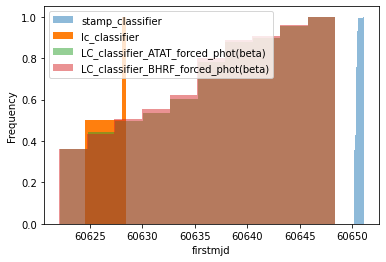

In [18]:
fig, ax = plt.subplots()
for key in sn.keys():
    alpha = 0.5
    if key == "lc_classifier":
        alpha = 1
    sn[key].firstmjd.plot.hist(ax=ax, alpha=alpha, cumulative=True, density=True, label=key)
    ax.set_xlabel("firstmjd")
    plt.legend()

Bar plot of classes per classifier

stamp_classifier
lc_classifier
LC_classifier_ATAT_forced_phot(beta)
LC_classifier_BHRF_forced_phot(beta)


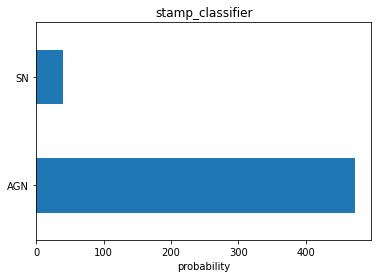

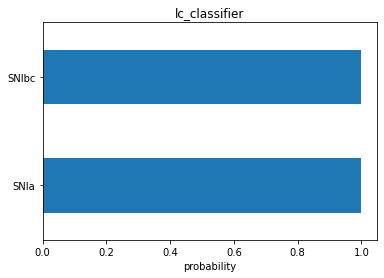

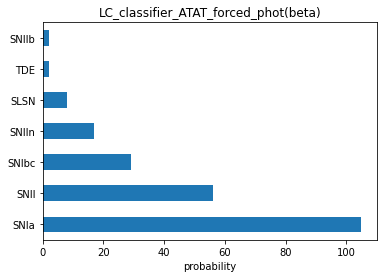

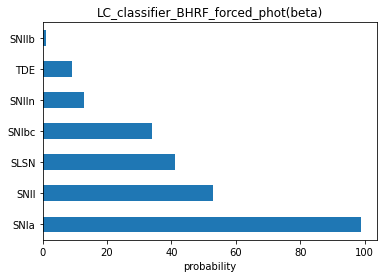

In [19]:
for key in sn.keys():
    print(key)
    fig, ax = plt.subplots()
    sn[key].class_name.value_counts().plot.barh()
    ax.set_xlabel("probability")
    ax.set_title(key)

stamp_classifier
lc_classifier
LC_classifier_ATAT_forced_phot(beta)
LC_classifier_BHRF_forced_phot(beta)


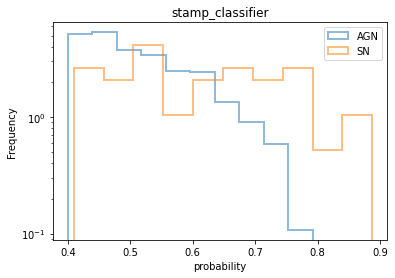

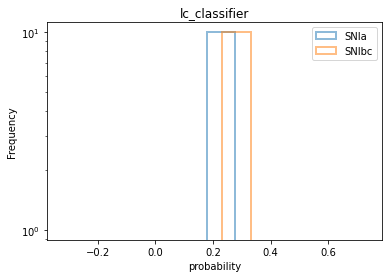

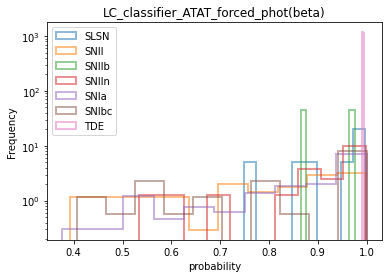

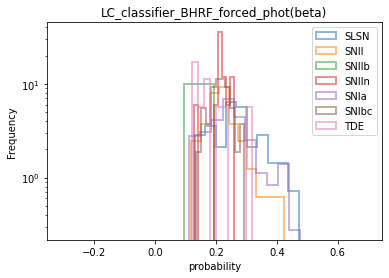

In [20]:
for key in sn.keys():
    print(key)
    fig, ax = plt.subplots()
    sn[key].groupby("class_name").apply(lambda df: df.probability.plot.hist(label=df.class_name[0], alpha=0.5, log=True, legend=True, density=True, histtype='step', lw=2, ax=ax))
    ax.set_xlabel("probability")
    ax.set_title(key)

Note that the probability distributions are very different between classifiers

# Generate link to quickly inspect all the candidates, starting with the top N most likely given a class

In [40]:
def dourlbatches(df, classifier_name, class_name, N):
    sel = df.loc[df.class_name==class_name].sort_values(by="probability").iloc[::-1].iloc[:N]
    batchsize = 100
    print(f"Classifier: {classifier_name}\nClass: {class_name}\n#events: {sel.shape[0]} (show top {min(N, sel.shape[0])} in batches of not more than {min(batchsize, sel.shape[0])} elements)")
    for ibatch in range(int(np.ceil((sel.shape[0]/batchsize)))):
        print(f"Batch {ibatch + 1}")
        suffix = f"&count=true&page=1&perPage=1000&sortDesc=true&selectedClassifier={classifier_name}"
        url = "https://alerce.online/?" + "&".join("oid=%s" % i for i in sel.iloc[ibatch * batchsize: (ibatch + 1) * batchsize].index) + suffix
        print(url)

Let's remind us about the different classifiers and the transient classes in each of them.

In [41]:
transients

{'stamp_classifier': ['SN', 'AGN'],
 'lc_classifier': ['SNIa', 'SNIbc', 'SNII', 'SLSN'],
 'LC_classifier_ATAT_forced_phot(beta)': ['SNIa',
  'SNIbc',
  'SNIIb',
  'SNII',
  'SNIIn',
  'SLSN',
  'TDE'],
 'LC_classifier_BHRF_forced_phot(beta)': ['SNIa',
  'SNIbc',
  'SNIIb',
  'SNII',
  'SNIIn',
  'SLSN',
  'TDE']}

In [43]:
classifier_name = "LC_classifier_ATAT_forced_phot(beta)"
class_name = "SNIa"
topN = 200
dourlbatches(sn[classifier_name], classifier_name, class_name, topN)

Classifier: LC_classifier_ATAT_forced_phot(beta)
Class: SNIa
#events: 105 (show top 105 in batches of not more than 100 elements)
Batch 1
https://alerce.online/?oid=ZTF24abugpzu&oid=ZTF24absmsee&oid=ZTF24abtgmpw&oid=ZTF24abtglxk&oid=ZTF24abufely&oid=ZTF24abrimib&oid=ZTF24abrmdti&oid=ZTF24abrnllc&oid=ZTF24abutaqg&oid=ZTF24absoxlw&oid=ZTF24abufpfb&oid=ZTF20aaispgr&oid=ZTF24abrossu&oid=ZTF24abtuwgx&oid=ZTF24abusxyl&oid=ZTF24abusvzr&oid=ZTF24abrkybg&oid=ZTF24absyxrj&oid=ZTF24abstuin&oid=ZTF24abtqxyy&oid=ZTF24abwsotz&oid=ZTF24abrpedj&oid=ZTF24abtsyyw&oid=ZTF24abtdxlo&oid=ZTF24abruaqt&oid=ZTF19aamqfxq&oid=ZTF24abubvjz&oid=ZTF17aadcedu&oid=ZTF24abwqgzu&oid=ZTF24abtsyol&oid=ZTF24abuhbco&oid=ZTF24abvevzs&oid=ZTF24abtdjad&oid=ZTF24absvyug&oid=ZTF24absrfgz&oid=ZTF24absmlws&oid=ZTF24abtlsjj&oid=ZTF24abvdzbs&oid=ZTF24abtberk&oid=ZTF24abwqimn&oid=ZTF24abuultp&oid=ZTF24abtekov&oid=ZTF24abusfrx&oid=ZTF24abrgpqk&oid=ZTF24abtqrea&oid=ZTF24abrpdla&oid=ZTF24abqvdhk&oid=ZTF24abstpyc&oid=ZTF24abugyce&oid=ZT

In [42]:
classifier_name = "LC_classifier_BHRF_forced_phot(beta)"
class_name = "TDE"
topN = 25
dourlbatches(sn[classifier_name], classifier_name, class_name, topN)

Classifier: LC_classifier_BHRF_forced_phot(beta)
Class: TDE
#events: 9 (show top 9 in batches of not more than 9 elements)
Batch 1
https://alerce.online/?oid=ZTF24abteglw&oid=ZTF24abugxai&oid=ZTF24abqvdlh&oid=ZTF24abtocmm&oid=ZTF24abuudqq&oid=ZTF24abuvitb&oid=ZTF24abvgooe&oid=ZTF24abvgeyz&oid=ZTF24abtldpk&count=true&page=1&perPage=1000&sortDesc=true&selectedClassifier=LC_classifier_BHRF_forced_phot(beta)


Note that objetcs that have been classified by the same classifier, but with different versions, will appear repeated in the explorer list